In [1]:
cd ../PlateData

/Users/sam/Documents/GitHub/transport_assay/PlateData


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PlateData import *

from mpl_interactions import hyperslicer

In [12]:
from statsmodels.nonparametric.kernel_regression import KernelReg

def OD_RFU_Kernel_Regression(baseline_ODs, baseline_RFUs, kernel_bw=0.1, plot_expand=1.1):
    
    '''
    Performs a nonparametric kernel regression on the ODs against the RFU values and returns
    a function to normalize all sample RFUs against RFUs for a similar OD value in the EV/EV sample.
    
    I am doing it this way because ODs and RFUs in the control samples (no FP) do not obey a linear or
    any other kind of simple functional form. This way I do not assume any functional form of the input;
    I simple flit a flexible gaussian kernel function to the points.
    
    Inputs:
        baseline ODs: the control ODs (e.g. the EV/EV sample), as a 1D array
        baseline RFUs: the corresponding RFUs from this sample
        
        kernel_bw (optional): the bandwidth of the kernel to use. this controls the smoothness of the function.
            statsmodels has default procedures to estimate this but I like to manually set a significantly higher
            one because I feel that their procedures overfit based on systematic noise (in particular, they assume
            that the noise is random, while the noise is in fact highly correlated since it is coming from time course
            data). Defaults to 0.1. Feel free to play with this.
            
    Output:
        kr_predict(): a function that takes in any array of OD values and spits back out the kernel regression
            prediction of what the RFUs would be for the baseline (EV/EV?) sample. Built to handle >1D arrays
            as well as nans (nans in the input will just remain nans in the output)
        a plot of the raw normalization data (gray scatter) and the kernel regression fit (red line)
    
    WARNING:
        this does NOT work if any of your sample ODs are outside of the range of the EV/EV ODs. If you wish to use
        this function in case, you have to truncate your data such that the sample ODs are all less than the EV/EV
        ODs. As you can probably see from the plot, the regressor will drift back toward ZERO above the range of the
        fitting data. It CANNOT extrapolate to larger values.
    '''

    # define and fit the kernel gression
    kr = KernelReg(exog=baseline_ODs,
                   endog=baseline_RFUs,
                   var_type="c",
                   bw=[kernel_bw])

    pred_y, marginal_effects = kr.fit()
    
    # make the data to plot
    plot_x = np.arange(0, np.max(baseline_ODs)*plot_expand, 0.01)
    kr_prediction_means = kr.fit(plot_x)[0]
    
    # plot the fit
    plt.figure(figsize=(5,5))
    plt.plot(plot_x, kr_prediction_means, c='red')
    plt.scatter(baseline_ODs, baseline_RFUs, c='gray', alpha=0.1)
    plt.xlabel("Baseline OD"); plt.ylabel("Baseline RFU")
    
    # defines a function to return
    def kr_predict(ods):
        
        '''
        This is the output function of the regression protocol and is what the function returns. Use this to
        normalize your raw data.
        
        Input:
            ods: a numpy array of OD values of any shape
        Output:
            rfu_pred: predicted RFU values, as an array of the same shape. nans will be carried over
        '''
        
        flattened_ods = ods.flatten()
        
        rfu_pred = np.zeros(len(flattened_ods))
        nonan = np.isnan(flattened_ods)==False
        rfu_pred[nonan] = kr.fit(flattened_ods[nonan])[0]
        rfu_pred[nonan==False] = np.nan
        
        return rfu_pred.reshape(ods.shape)
    
    return kr_predict

def readNeoData(filename, directory="./", n_channels=2, sheets=["Plate 1", "Plate 2", "Plate 3"]):

    NeoData = {}; t_offset = 5

    for sheet_name in sheets:

        NeoData[sheet_name] = {}

        test_df = pd.read_excel(directory + filename, sheet_name=sheet_name, header=0) 

        channel_starts = []; channel_names = []
        for nchan in range(n_channels):
            cstart = np.where(["Read "+str(nchan+1)+":" in str(i) for i in test_df[test_df.columns[0]]])[0][0]

            channel_starts.append(cstart)

            channel_names.append(test_df.iloc[cstart][0].split(":")[1])

        results_index = np.where(["Results" in str(i) for i in test_df[test_df.columns[0]]])[0][0]
        channel_starts.append(results_index)

        for nchan in range(n_channels):
            neo_df = pd.read_excel(directory + filename, sheet_name=sheet_name, header=channel_starts[nchan]+3, 
                                   nrows=channel_starts[nchan+1] - channel_starts[nchan] - 4)

            neo_df = neo_df.drop(columns=neo_df.columns[0], axis=1).dropna(axis=1, how="all").dropna(axis=0)

            NeoData[sheet_name][channel_names[nchan]] = neo_df

    NewDFs = {}

    for channel in channel_names:

        data_holder = []

        for n,sheet_name in enumerate(sheets):

            data = NeoData[sheet_name][channel] 

            # If the data holder is empty (this is the first sheet we're adding from)
            #   we don't need to set a time offset
            if len(data_holder)==0:
                t_off = 0

            # otherwise we'll add the previous times onto our time measurement
            #  in addition to an 'offset' for the time not counted between sheets
            #  (defaults to 5 minutes)
            else:
                t_off = np.max(data_holder[-1]["Time"]) + n*t_offset

            data["Time"] = [time.hour*60 + time.minute + time.second / 60 + t_off for time in data["Time"]]

            data_holder.append(data)

            concatenated_data = pd.concat(data_holder)
            concatenated_data.index = np.arange(len(concatenated_data))

            NewDFs[channel] = concatenated_data
            
    return NewDFs


In [13]:
directory =  "/Users/sam/Dropbox (Harvard University)/Data/Mn_reporter_assay/"
filename = "071222/pSB1_plate_07122_timecourse.xlsx"



row_annotations = {'[MnCl2]': [1000, 100, 0, 1000, 100, 0],
                   'use_row': [True, True, True, True, True, True],
                   'rep': [0, 0, 0, 1, 1, 1]}

col_annotations = {'reporter': ['pSB1-EV', 'pSB1em2', 'pSB1em2', 'pSB1em2'],
                   'construct': ['EV', 'EV', 'Drad WT', 'DraNramp D56A'],
                   'sample': [0,1,2,3],
                   'use_col': [True, True, True, True]}

neo_data = readNeoData(filename, directory=directory)

Exp_0712 = PlateAssay((neo_data["473,528"], neo_data["600"]), df_keys=("RFU", "OD"), 
                 row_annotations=row_annotations, col_annotations=col_annotations)

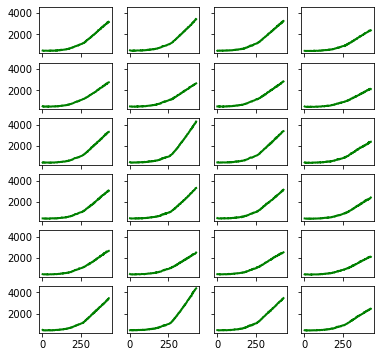

In [14]:
%matplotlib inline
fig, ax = plt.subplots(6, 4, 
                       figsize=(6,6),
                                sharey=True, sharex=True)

for i in range(0, 6):
    for j in range(0, 4):
        ax[(i-1,j-1)].plot(Exp_0712.times, Exp_0712["RFU"][:,i,j], c="Green", lw=2)

(array([3.69645167, 1.00438108, 0.77386739, 0.68330844, 0.74093686,
        0.60098212, 0.43632948, 0.79033265, 1.10317266, 0.44456212]),
 array([0.0535 , 0.15083, 0.24816, 0.34549, 0.44282, 0.54015, 0.63748,
        0.73481, 0.83214, 0.92947, 1.0268 ]),
 <BarContainer object of 10 artists>)

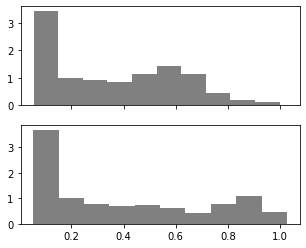

In [15]:
fig,ax = plt.subplots(2,1,figsize=(5,4), sharex=True)
ax[0].hist(Exp_0712.select({"sample":lambda x:x>0, "use_row":True})["OD"], density=True, color='gray')
ax[1].hist(Exp_0712.select({"sample":0, "use_row":True})["OD"], density=True, color='gray')

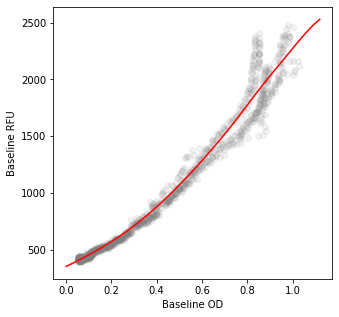

In [16]:
f = OD_RFU_Kernel_Regression(Exp_0712.select({"col":0, "use_row":True})['OD'],
                         Exp_0712.select({"col":0, "use_row":True})['RFU'],
                         kernel_bw=0.1, plot_expand=1.1)

In [17]:
Exp_0712["RFU_simple_norm"] = Exp_0712["RFU"] - Exp_0712["RFU"][:,:,0].reshape(208,6,-1)
Exp_0712["RFU_kr_norm"] = Exp_0712["RFU"] - f(Exp_0712["OD"])

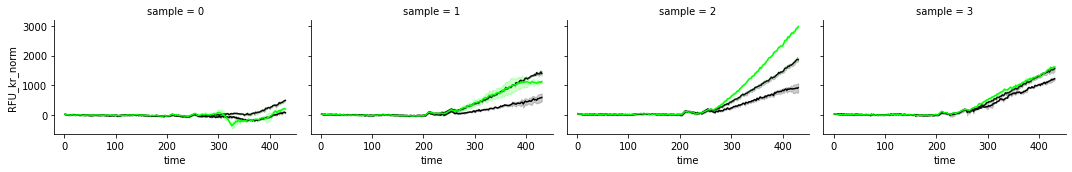

In [18]:
Exp_0712.grid("RFU_kr_norm", col="sample", hue="[MnCl2]", 
              palette = sns.blend_palette(['black', 'lime'], as_cmap=True))

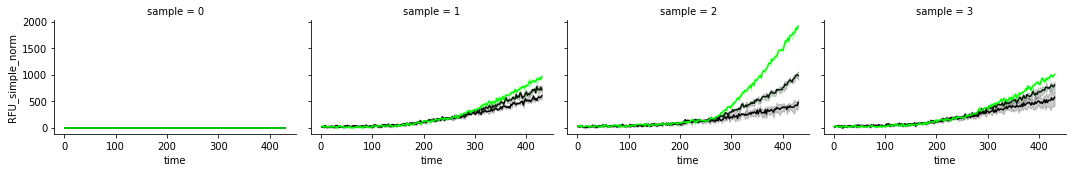

In [19]:
Exp_0712.grid("RFU_simple_norm", col="sample", hue="[MnCl2]",
             palette = sns.blend_palette(['black', 'lime'], as_cmap=True))